In [156]:
!pip install pandas
!pip install numpy
!pip install joblib
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install imbalanced-learn



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from imblearn.combine import SMOTETomek 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [158]:
tr = pd.read_csv('train.csv')
val = pd.read_csv('valid.csv')

In [159]:
tr.info()

val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB


In [160]:
tr.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [161]:
val.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


<Axes: >

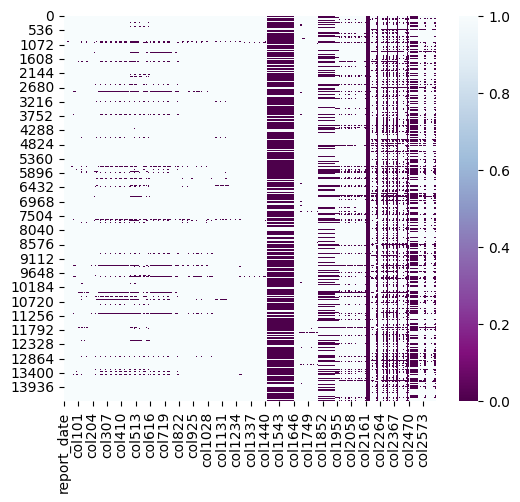

In [162]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr.isnull(), cmap='BuPu_r')

In [163]:
def drop_columns(df, threshold=0.7):
    counts = df.isna().sum()

    # Удаляем столбцы, в которых количество пропусков 30%
    dropped_columns = [column for column in counts.index if counts[column] > threshold * len(df)]
    return df.drop(dropped_columns, axis=1)

# Применяем функцию 
tr = drop_columns(tr)
val = drop_columns(val)



In [164]:
tr.shape

(14456, 503)

<Axes: >

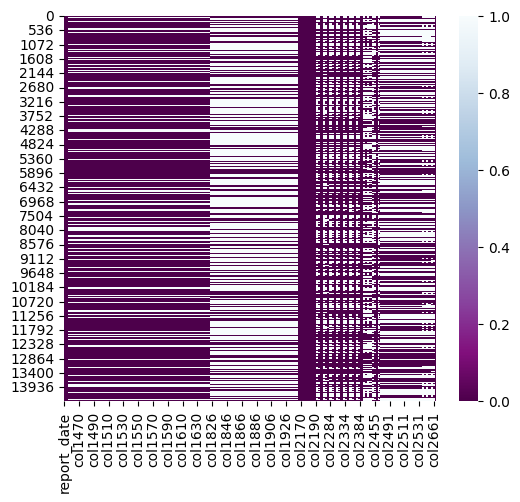

In [165]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr.isnull(), cmap='BuPu_r')

In [166]:
# Заполнение пропущенных значений
for col in val:
    if val[col].dtype in ['float64', 'int64']:  # Если колонка числовая
        val[col] = val[col].fillna(val[col].median())
    elif val[col].dtype == 'object':  # Если колонка текстовая
        val[col] = val[col].fillna('unknown')

In [167]:
# Заполнение пропущенных значений
for col in tr.columns:
    if tr[col].dtype in ['float64', 'int64']:  # Если колонка числовая
        tr[col] = tr[col].fillna(tr[col].median())
    elif tr[col].dtype == 'object':  # Если колонка текстовая
        tr[col] = tr[col].fillna('unknown')

In [168]:
tr.select_dtypes(include=['object'])

,report_date,col1454
0,2022-11-01,00f3d719-a6ec-4960-ba01-8372eb705443
1,2022-11-01,01febac0-b083-494e-8589-f98400074b94
2,2022-05-01,0278175e-c0bb-4e1e-bfe5-20db6811d3e2
3,2022-09-01,0364571d-5325-ed11-b823-005056b825cd
4,2022-08-01,065957a6-9b2a-435a-b561-024e9e8d9ad7
...,...,...
14451,2022-07-01,fc4b5aa0-c4d6-4394-93db-57a1505e66c4
14452,2022-09-01,fcc827d8-b64b-4b59-b718-87f2a51d77a4
14453,2022-02-01,fd5f22f5-36f6-4dca-9896-8c9e90bbb702
14454,2021-08-01,fdf04fb7-5404-4a9c-ae5b-e1e893060631


In [169]:
tr_client1 = tr[tr['client_id'] == 4231]
tr_client2 = tr[tr['client_id'] == 4232]

In [170]:
tr_client1

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
3892,2021-06-01,4231,0,0,4cdefd0d-c320-49c5-b859-7af613fbe93f,0.0,0.0,0.0,0.0,1.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261
4505,2022-04-01,4231,0,0,4cdefd0d-c320-49c5-b859-7af613fbe93f,0.0,0.0,0.0,2.0,2.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261
6559,2022-11-01,4231,0,0,4cdefd0d-c320-49c5-b859-7af613fbe93f,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261
14235,2022-12-01,4231,0,0,4cdefd0d-c320-49c5-b859-7af613fbe93f,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,6244578.0,6146773.5,6225550.0,0.256261


In [171]:
tr_client2

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
3895,2022-10-01,4232,0,1,4d07daa5-544a-49a5-b5ec-2f67efc38ac4,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,0.256718
3896,2023-01-01,4232,0,0,4d07daa5-544a-49a5-b5ec-2f67efc38ac4,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,8167000.0,8167000.0,8167000.0,0.256718
5097,2022-01-01,4232,0,0,4d07daa5-544a-49a5-b5ec-2f67efc38ac4,0.0,0.0,0.0,0.0,1.0,...,242.0,242.0,242.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,0.256718
7392,2022-11-01,4232,0,1,4d07daa5-544a-49a5-b5ec-2f67efc38ac4,0.0,0.0,0.0,0.0,0.0,...,242.0,242.0,242.0,6240000.0,6164000.0,6224000.0,8167000.0,8167000.0,8167000.0,0.256718
8279,2021-12-01,4232,0,0,4d07daa5-544a-49a5-b5ec-2f67efc38ac4,0.0,0.0,0.0,0.0,1.0,...,242.0,242.0,242.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,8167000.0,0.256718


In [172]:
tr.drop('col1454' , axis = 1 , inplace = True)
val.drop('col1454' , axis = 1 , inplace = True)

<Axes: >

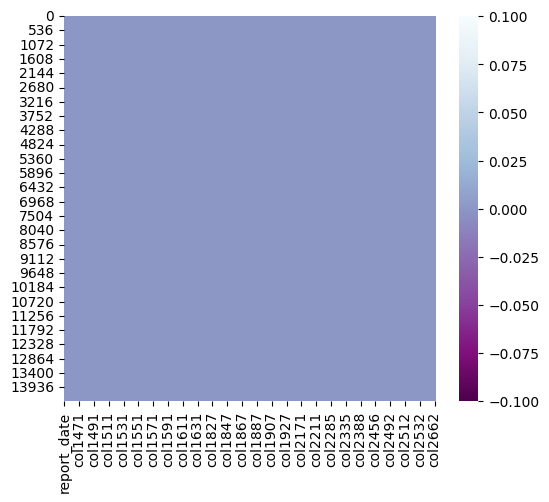

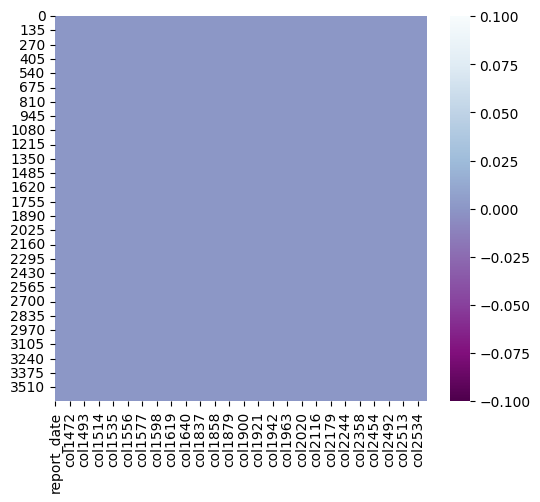

In [173]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr.isnull(), cmap='BuPu_r')

plt.figure(figsize=(6, 5))
sns.heatmap(val.isnull(), cmap='BuPu_r')

In [174]:
tr['report_date'] = pd.to_datetime(tr['report_date'])
val['report_date'] = pd.to_datetime(val['report_date'])

In [175]:
def del_duble(tr):
  unique_columns = []
  for column in tr.columns:
    if not any(tr[column].equals(tr[col]) for col in unique_columns):
      unique_columns.append(column)
  return tr[unique_columns]

tr = del_duble(tr)
tr.shape

(14456, 273)

In [176]:
def del_duble(val):
  unique_columns = []
  for column in val.columns:
    if not any(val[column].equals(val[col]) for col in unique_columns):
      unique_columns.append(column)
  return val[unique_columns]

val = del_duble(val)
val.shape

(3642, 289)

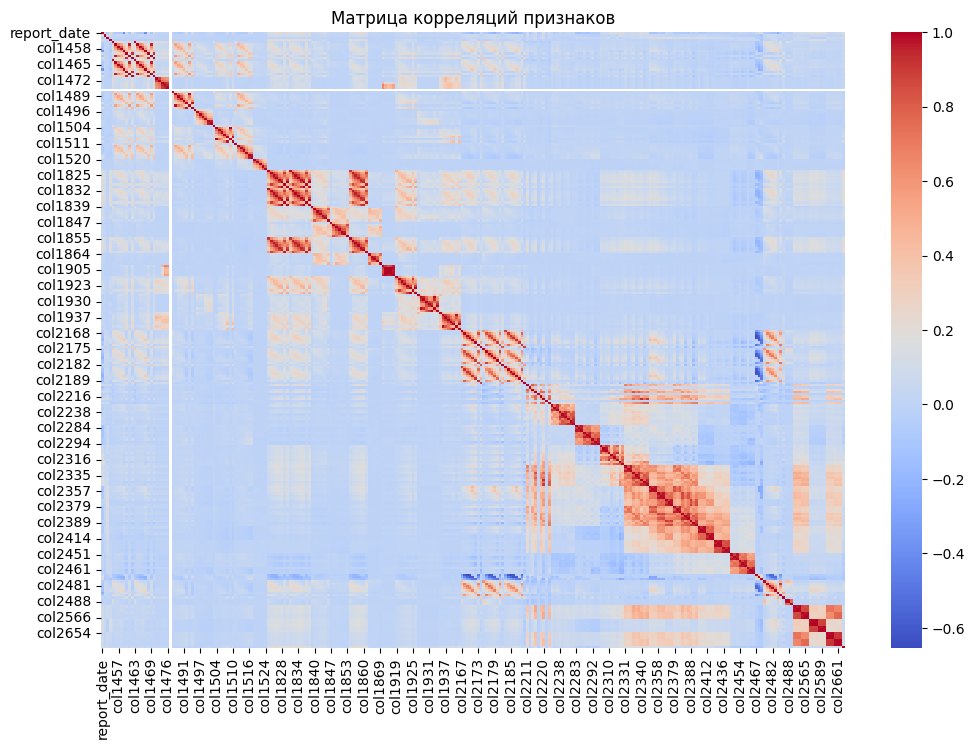

In [177]:
correlation_matrix = tr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций признаков')
plt.show()

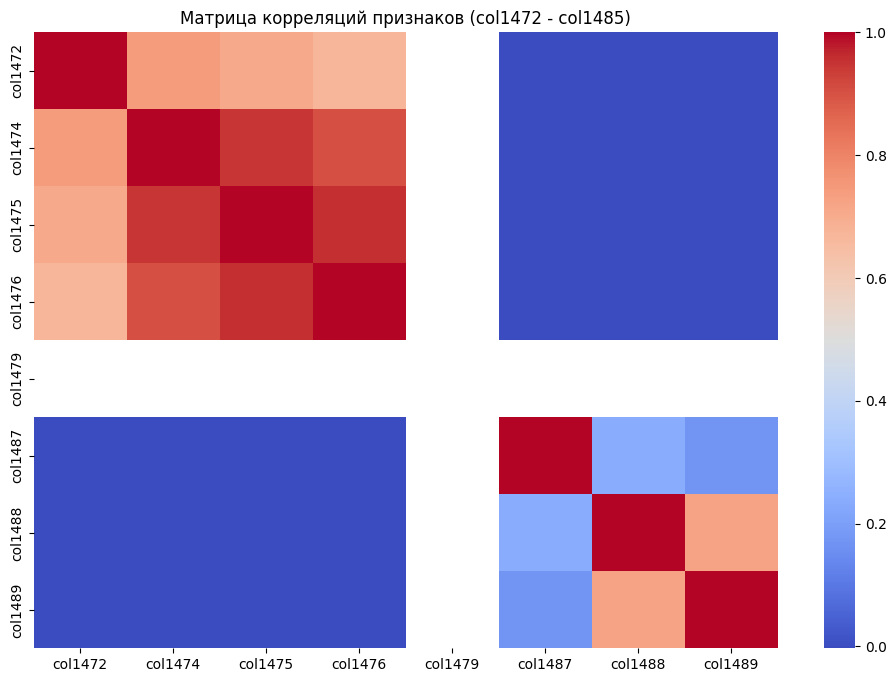

In [178]:
selected_columns = tr.loc[:, 'col1472':'col1489']
correlation_matrix = selected_columns.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций признаков (col1472 - col1485)')
plt.show()

In [179]:
tr.drop('col1479' , axis = 1 , inplace = True)

tr.drop('col2663' , axis = 1 , inplace = True)
val.drop('col2663' , axis = 1 , inplace = True)

In [146]:
tr.to_csv('tr.csv', index=False)
val.to_csv('val.csv', index=False)

In [147]:
# # Подсчет количества непустых значений в каждой строке
# tr['non_null_count'] = tr.apply(lambda row: row.count(), axis=1)
# # Сортировка по количеству непустых значений в порядке убывания
# tr = tr.sort_values(by='non_null_count', ascending=False)
# # Оставляем только 5000 самых заполненных строк
# tr = tr.head(5000)
# # Удаляем временный столбец 'non_null_count'
# tr = tr.drop(columns=['non_null_count'])

In [183]:
# Оставляем только те колонки в валидационном датасете, которые есть в обучающем
val = tr[tr.columns.intersection(tr.columns)]
missing_columns = set(tr.columns) - set(tr.columns)

for col in missing_columns:
    val[col] = 0  # Или другое значение, например, среднее/медиану по обучающему набору

# Приводим порядок колонок к обучающему набору
val = val[tr.columns]

In [192]:


X = tr.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = tr['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


categorical_columns = X_train.select_dtypes(include=['object']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns].astype(str))
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns].astype(str))


random_forest_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features='sqrt',  
    bootstrap=True,
    oob_score=True
)

pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)),  # Балансировка классов
    ('rf', random_forest_model)
])


param_distributions = {
    'rf__n_estimators': [50, 75, 100], 
    'rf__max_depth': [3, 4, 5],         
    'rf__min_samples_split': [30, 40, 50], 
    'rf__min_samples_leaf': [20, 30, 40],   
    'rf__class_weight': ['balanced']        
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)


random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Лучшие параметры модели:", random_search.best_params_)
print("\nROC-AUC на тестовых данных:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report на тестовых данных:\n", classification_report(y_test, best_model.predict(X_test)))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'rf__n_estimators': 75, 'rf__min_samples_split': 50, 'rf__min_samples_leaf': 20, 'rf__max_depth': 5, 'rf__class_weight': 'balanced'}

ROC-AUC на тестовых данных: 0.8003401151474173

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      2805
           1       0.12      0.56      0.19        87

    accuracy                           0.86      2892
   macro avg       0.55      0.72      0.56      2892
weighted avg       0.96      0.86      0.90      2892




ROC-AUC на валидационных данных: 0.8702184952034446


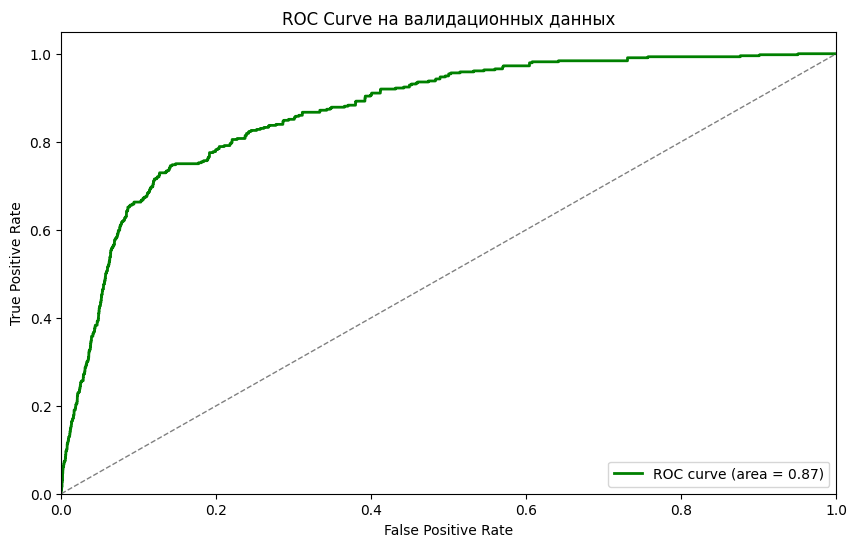

In [ ]:


X_valid = val.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = val['target']
X_valid[categorical_columns] = ordinal_encoder.transform(X_valid[categorical_columns].astype(str))


y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("\nROC-AUC на валидационных данных:", roc_auc_valid)

fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
roc_auc_valid_curve = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(10, 6))
plt.plot(fpr_valid, tpr_valid, color='green', lw=2, label=f'ROC curve (area = {roc_auc_valid_curve:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на валидационных данных')
plt.legend(loc="lower right")
plt.show()